# Multi-Class Classification Model for Kaggle Tabular Playground Series June 2021 Using Python and AutoKeras
### David Lowe
### January 13, 2022

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Kaggle Tabular Playground Series June 2021 dataset is a multi-class modeling situation where we are trying to predict one of several (more than two) possible outcomes.

INTRODUCTION: Kaggle wants to provide an approachable environment for relatively new people in their data science journey. Since January 2021, they have hosted playground-style competitions on Kaggle with fun but less complex, tabular datasets. The dataset used for this competition is synthetic but based on a real dataset and generated using a CTGAN. The original dataset deals with predicting the category on an eCommerce product given various attributes about the listing. Although the features are anonymized, they have properties relating to real-world features.

ANALYSIS: After a series of tuning trials, the best AutoKeras model processed the training dataset with a logarithmic loss of 1.7691. When we processed the test dataset with the final model, the model achieved a logarithmic loss of 1.7686.

CONCLUSION: In this iteration, the AutoKeras model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Kaggle Tabular Playground 2021 June Data Set

Dataset ML Model: Multi-Class classification with categorical attributes

Dataset Reference: https://www.kaggle.com/c/tabular-playground-series-jun-2021/

One potential source of performance benchmark: https://www.kaggle.com/c/tabular-playground-series-jun-2021/leaderboard

## Task 1 - Prepare Environment

In [1]:
# # Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL

In [2]:
# Retrieve the GPU information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Tue Jan 11 03:50:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 5000     Off  | 00000000:00:05.0 Off |                  Off |
| 33%   36C    P8    10W / 230W |      0MiB / 16125MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Retrieve the memory configuration from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 31.6 gigabytes of available RAM



In [4]:
# # Mount Google Drive locally for loading the dotenv files
# from dotenv import load_dotenv
# from google.colab import drive
# drive.mount('/content/gdrive')
# gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
# env_path = '/content/gdrive/My Drive/Colab Notebooks/'
# dotenv_path = env_path + "python_script.env"
# load_dotenv(dotenv_path=dotenv_path)

In [5]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 8


### 1.a) Load libraries and modules

In [6]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [7]:
import random
random.seed(RNG_SEED)
import numpy as np
np.random.seed(RNG_SEED)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
# import boto3
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute

# from sklearn.feature_selection import RFE
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler

import tensorflow as tf
tf.random.set_seed(RNG_SEED)
import keras_tuner
import autokeras as ak

2022-01-11 03:50:06.398741: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


### 1.b) Set up the controlling parameters and functions

In [8]:
# Begin the timer for the script processing
START_TIME_SCRIPT = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.2
VAL_SET_RATIO = 0.2

# Set the number of folds for cross validation
N_FOLDS = 5
N_ITERATIONS = 1

# Set various default modeling parameters
DEFAULT_LOSS = 'categorical_crossentropy'
DEFAULT_METRICS = ['categorical_crossentropy']
MAX_EPOCHS = 10
BATCH_SIZE = 32
MAX_TRIALS = 10

# Define the directory locations and file names
TRAIN_DATASET = 'train.csv'
TEST_DATASET = 'test.csv'

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Num GPUs Available: 1
TensorFlow version: 2.5.2


2022-01-11 03:50:07.656597: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-01-11 03:50:07.681337: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-11 03:50:07.682233: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:05.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-01-11 03:50:07.682303: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-01-11 03:50:07.688119: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-01-11 03:50:07.688205: I tensorflow/stream_executor/platform/d

In [9]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [10]:
# Reset the random number generators
def reset_random(x=RNG_SEED):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [11]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [12]:
if not os.path.exists(TRAIN_DATASET):
    !wget https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021jun/train.csv

--2022-01-11 03:50:08--  https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021jun/train.csv
Resolving dainesanalytics.com (dainesanalytics.com)... 13.32.151.31, 13.32.151.98, 13.32.151.78, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|13.32.151.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33352514 (32M) [text/csv]
Saving to: ‘train.csv’

train.csv           100%[===================>]  31.81M  21.8MB/s    in 1.5s    

2022-01-11 03:50:09 (21.8 MB/s) - ‘train.csv’ saved [33352514/33352514]



In [13]:
df_dataset_import = pd.read_csv(TRAIN_DATASET)

# Take a peek at the dataframe after import
print(df_dataset_import.head(10))

   id  feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   0          0          0          6          1          0          0   
1   1          0          0          0          0          0          0   
2   2          0          0          0          0          0          1   
3   3          0          0          7          0          1          5   
4   4          1          0          0          0          0          0   
5   5          0         15          0          0          0          1   
6   6          0          1          2          1          0          2   
7   7          2          3          5          0          0          1   
8   8          1          0          0         35          6          2   
9   9          0          0          0          0          0          0   

   feature_6  feature_7  feature_8  ...  feature_66  feature_67  feature_68  \
0          0          0          7  ...           0           0           0   
1          0    

In [14]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 77 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          200000 non-null  int64 
 1   feature_0   200000 non-null  int64 
 2   feature_1   200000 non-null  int64 
 3   feature_2   200000 non-null  int64 
 4   feature_3   200000 non-null  int64 
 5   feature_4   200000 non-null  int64 
 6   feature_5   200000 non-null  int64 
 7   feature_6   200000 non-null  int64 
 8   feature_7   200000 non-null  int64 
 9   feature_8   200000 non-null  int64 
 10  feature_9   200000 non-null  int64 
 11  feature_10  200000 non-null  int64 
 12  feature_11  200000 non-null  int64 
 13  feature_12  200000 non-null  int64 
 14  feature_13  200000 non-null  int64 
 15  feature_14  200000 non-null  int64 
 16  feature_15  200000 non-null  int64 
 17  feature_16  200000 non-null  int64 
 18  feature_17  200000 non-null  int64 
 19  feature_18  200000 non-

In [15]:
print(df_dataset_import.describe())

                  id      feature_0      feature_1      feature_2  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean    99999.500000       0.972710       1.168365       2.219325   
std     57735.171256       3.941836       3.993407       6.476570   
min         0.000000       0.000000       0.000000       0.000000   
25%     49999.750000       0.000000       0.000000       0.000000   
50%     99999.500000       0.000000       0.000000       0.000000   
75%    149999.250000       1.000000       1.000000       1.000000   
max    199999.000000      61.000000      51.000000      64.000000   

           feature_3      feature_4      feature_5      feature_6  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        2.296735       0.793530       1.431105       1.010695   
std         7.551858       2.935785       5.162746       3.949231   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.0000

In [16]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

id            0
feature_0     0
feature_1     0
feature_2     0
feature_3     0
             ..
feature_71    0
feature_72    0
feature_73    0
feature_74    0
target        0
Length: 77, dtype: int64
Total number of NaN in the dataframe:  0


### 1.d) Data Cleaning

In [17]:
# Dropping features
df_dataset_import.drop(columns=['id'], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head(10))

   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0          0          0          6          1          0          0   
1          0          0          0          0          0          0   
2          0          0          0          0          0          1   
3          0          0          7          0          1          5   
4          1          0          0          0          0          0   
5          0         15          0          0          0          1   
6          0          1          2          1          0          2   
7          2          3          5          0          0          1   
8          1          0          0         35          6          2   
9          0          0          0          0          0          0   

   feature_6  feature_7  feature_8  feature_9  ...  feature_66  feature_67  \
0          0          0          7          0  ...           0           0   
1          0          0          0          0  ...           2

In [18]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 76 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   feature_0   200000 non-null  int64 
 1   feature_1   200000 non-null  int64 
 2   feature_2   200000 non-null  int64 
 3   feature_3   200000 non-null  int64 
 4   feature_4   200000 non-null  int64 
 5   feature_5   200000 non-null  int64 
 6   feature_6   200000 non-null  int64 
 7   feature_7   200000 non-null  int64 
 8   feature_8   200000 non-null  int64 
 9   feature_9   200000 non-null  int64 
 10  feature_10  200000 non-null  int64 
 11  feature_11  200000 non-null  int64 
 12  feature_12  200000 non-null  int64 
 13  feature_13  200000 non-null  int64 
 14  feature_14  200000 non-null  int64 
 15  feature_15  200000 non-null  int64 
 16  feature_16  200000 non-null  int64 
 17  feature_17  200000 non-null  int64 
 18  feature_18  200000 non-null  int64 
 19  feature_19  200000 non-

In [19]:
print(df_dataset_import.describe())

           feature_0      feature_1      feature_2      feature_3  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        0.972710       1.168365       2.219325       2.296735   
std         3.941836       3.993407       6.476570       7.551858   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         1.000000       1.000000       1.000000       1.000000   
max        61.000000      51.000000      64.000000      70.000000   

           feature_4      feature_5      feature_6      feature_7  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        0.793530       1.431105       1.010695       0.673090   
std         2.935785       5.162746       3.949231       2.234949   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.0000

In [20]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

feature_0     0
feature_1     0
feature_2     0
feature_3     0
feature_4     0
             ..
feature_71    0
feature_72    0
feature_73    0
feature_74    0
target        0
Length: 76, dtype: int64
Total number of NaN in the dataframe:  0


### 1.e) Splitting Data into Sets

In [21]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_train = df_dataset_import['target']
df_features_train = df_dataset_import.drop(['target'], axis=1)

print("df_dataset_import.shape: {} df_features_train.shape: {} df_target_train.shape: {}".format(df_dataset_import.shape, df_features_train.shape, df_target_train.shape))

df_dataset_import.shape: (200000, 76) df_features_train.shape: (200000, 75) df_target_train.shape: (200000,)


### 1.f) Set up the parameters for data visualization

In [22]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1

# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [23]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [24]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

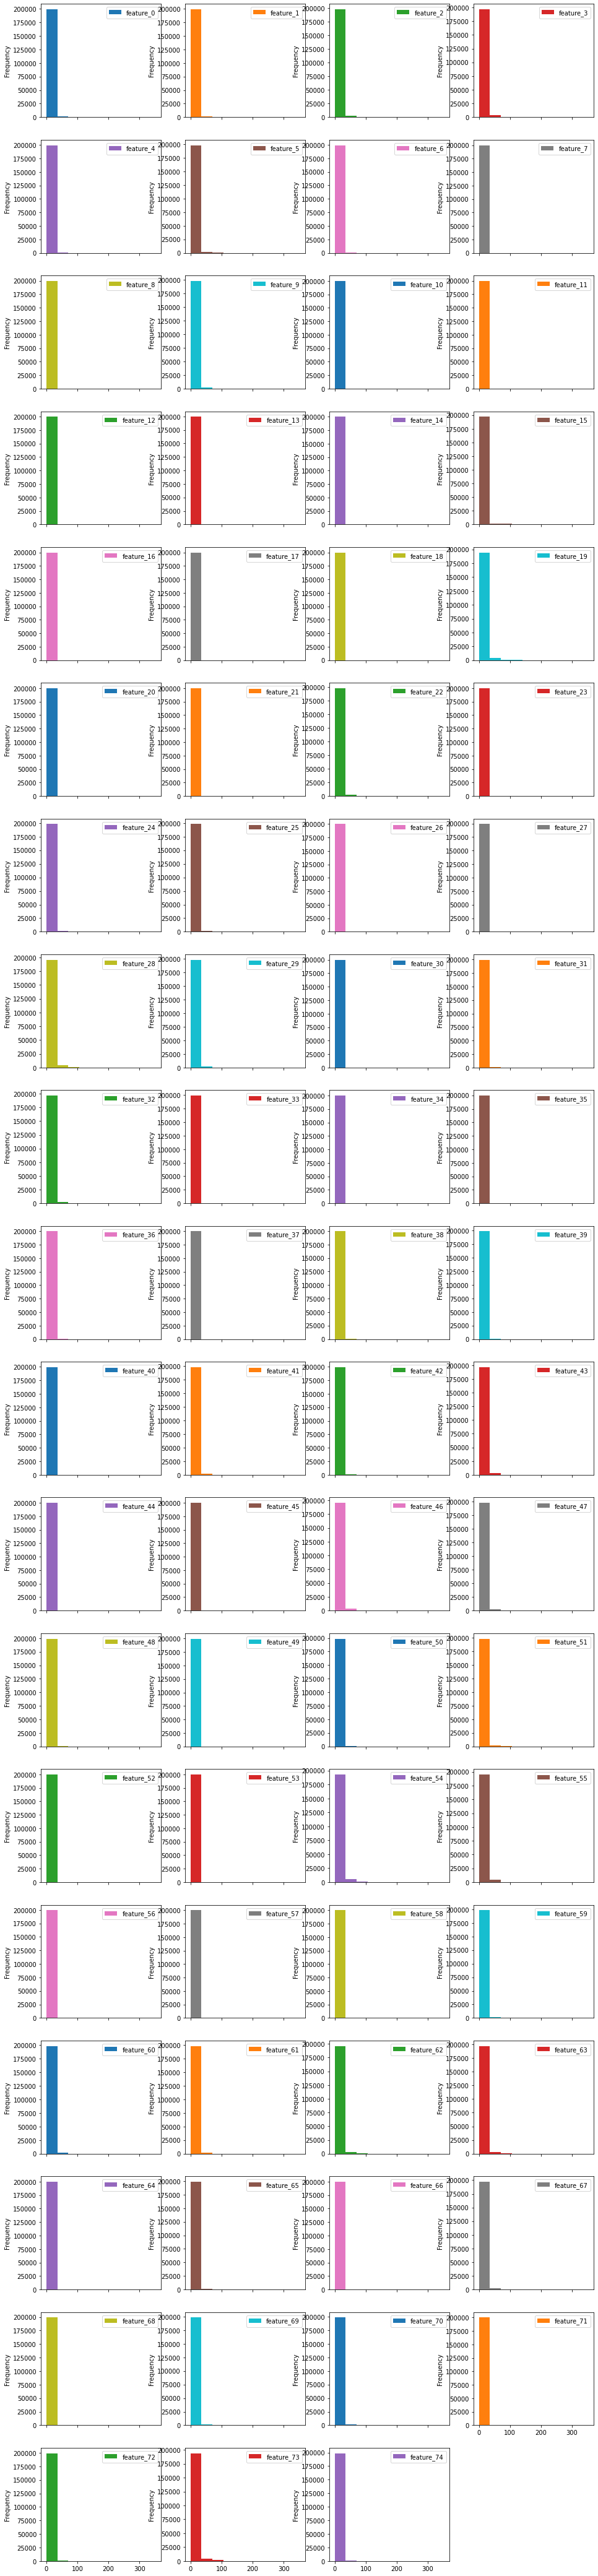

In [25]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

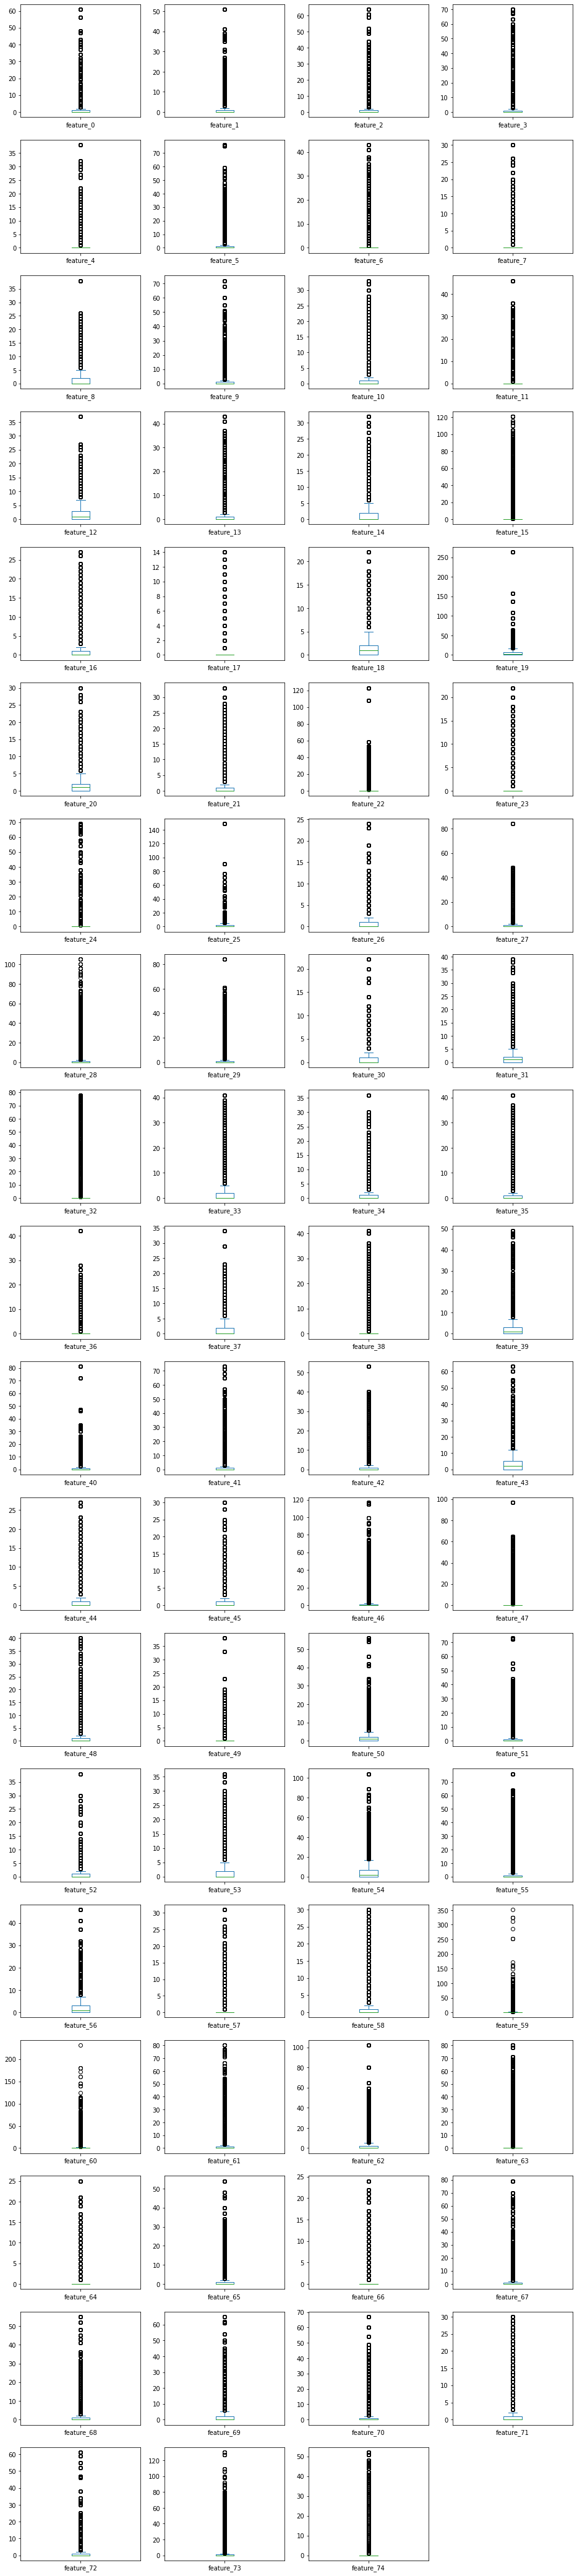

In [26]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

In [27]:
# # Correlation matrix
# fig = plt.figure(figsize=(20, 20))
# correlations = df_features_train.corr(method='pearson')
# sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
# plt.show()

In [28]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [29]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Scaling and Data Pre-Processing

In [30]:
# # Compose pipeline for the numerical and categorical features (Block #1 of 2)
# numeric_columns = df_features_train.select_dtypes(include=['int64','float64']).columns
# numeric_transformer = Pipeline(steps=[
#     ('imputer', impute.SimpleImputer(strategy="constant", fill_value=0)),
#     ('scaler', preprocessing.MinMaxScaler())
# ])
# categorical_columns = df_features_train.select_dtypes(include=['object','bool','category']).columns
# categorical_transformer = Pipeline(steps=[
#     ('imputer', impute.SimpleImputer(strategy='constant', fill_value='UKNOWN')),
#     ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
# ])

# print("Number of numerical columns:", len(numeric_columns))
# print("Number of categorical columns:", len(categorical_columns))
# print("Total number of columns in the feature dataframe:", df_features_train.shape[1])

In [31]:
# # Compose pipeline for the numerical and categorical features (Block #2 of 2)
# preprocessor = compose.ColumnTransformer(transformers=[
#     ('num', numeric_transformer, numeric_columns),
#     ('cat', categorical_transformer, categorical_columns)
# ])

# # Display the shapes of the training dataset for final inspection
# array_features_train = preprocessor.fit_transform(df_features_train)
# print("Transformed features from df_features_train.shape: {} to array_features_train.shape: {}".format(df_features_train.shape, array_features_train.shape))

### 3.b) Training Data Balancing

In [32]:
# Not applicable for this iteration of the project

In [33]:
# Perform SMOTE transformation on the training data (Block #1 of 2)

# X_train_imbal = X_train_df.values
# y_train_imbal = y_train_df.values.ravel()
# print("X_train_imbal.shape: {} y_train_imbal.shape: {}".format(X_train_imbal.shape, y_train_imbal.shape))

In [34]:
# Perform SMOTE transformation on the training data (Block #2 of 2)

# print ('Original class distribution - 1: {} | 0: {}'.format((y_train_imbal==1).sum(), (y_train_imbal==0).sum()))
# sm = SMOTE(random_state=RNG_SEED, sampling_strategy=1.0)
# X_trainSmote, y_trainSmote = sm.fit_sample(X_train_imbal, y_train_imbal)
# print ('Resampled class distribution - 1: {} | 0: {}'.format((y_train==1).sum(), (y_train==0).sum()))

### 3.c) Display the Final Datasets for Model-Building

In [35]:
# Finalize the training dataset for the modeling activities
array_features_train = df_features_train.to_numpy()
# array_target_train = df_target_train.ravel()
label_encoder = preprocessing.LabelEncoder()
array_target_train = tf.keras.utils.to_categorical(label_encoder.fit_transform(df_target_train))
print("array_features_train.shape: {} array_target_train.shape: {}".format(array_features_train.shape, array_target_train.shape))

array_features_train.shape: (200000, 75) array_target_train.shape: (200000, 9)


In [36]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Tune Models

In [37]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [38]:
start_time_module = datetime.now()
reset_random()
auto_model = ak.StructuredDataClassifier(loss=DEFAULT_LOSS,
                                         metrics=DEFAULT_METRICS,
                                         max_trials=MAX_TRIALS,
                                         objective=keras_tuner.Objective("val_loss", direction="min"),
                                         seed=RNG_SEED)
auto_model.fit(x=array_features_train,
               y=array_target_train,
               epochs=MAX_EPOCHS,
               validation_split=VAL_SET_RATIO,
               batch_size=BATCH_SIZE,
               verbose=1)
print('Total time for model fitting:', (datetime.now() - start_time_module))

Trial 10 Complete [00h 12m 47s]
val_loss: 1.7691760063171387

Best val_loss So Far: 1.7691760063171387
Total elapsed time: 01h 37m 36s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
6250/6250 [==============================] - 52s 8ms/step - loss: 1.8619 - categorical_crossentropy: 1.8619
Epoch 2/10
6250/6250 [==============================] - 51s 8ms/step - loss: 1.8095 - categorical_crossentropy: 1.8095
Epoch 3/10
6250/6250 [==============================] - 50s 8ms/step - loss: 1.7999 - categorical_crossentropy: 1.7999
Epoch 4/10
6250/6250 [==============================] - 51s 8ms/step - loss: 1.7946 - categorical_crossentropy: 1.7946
Epoch 5/10
6250/6250 [==============================] - 50s 8ms/step - loss: 1.7908 - categorical_crossentropy: 1.7908
Epoch 6/10
6250/6250 [==============================] - 50s 8ms/step - loss: 1.7889 - categorical_crossentropy: 1.7889
Epoch 7/10
6250/6250 [==============================] - 50s 8ms/step - loss: 1.7866 - categorical_crossentropy: 1

2022-01-11 05:41:59.063188: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./structured_data_classifier/best_model/assets
Total time for model fitting: 1:51:34.246199


In [39]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Make Predictions

In [40]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Train the Final Model

In [41]:
final_model = auto_model.export_model()
final_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 75)]              0         
_________________________________________________________________
multi_category_encoding (Mul (None, 75)                0         
_________________________________________________________________
normalization (Normalization (None, 75)                151       
_________________________________________________________________
dense (Dense)                (None, 128)               9728      
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
re_lu (ReLU)                 (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0     

### 5.b) Load Test Dataset and Make Predictions

In [42]:
if not os.path.exists(TEST_DATASET):
    !wget https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021jun/test.csv

--2022-01-11 05:42:08--  https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021jun/test.csv
Resolving dainesanalytics.com (dainesanalytics.com)... 99.86.231.62, 99.86.231.119, 99.86.231.69, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|99.86.231.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15931202 (15M) [text/csv]
Saving to: ‘test.csv’

test.csv            100%[===================>]  15.19M  17.3MB/s    in 0.9s    

2022-01-11 05:42:09 (17.3 MB/s) - ‘test.csv’ saved [15931202/15931202]



In [43]:
df_features_test = pd.read_csv(TEST_DATASET)

# Take a peek at the dataframe after import
print(df_features_test.head())

       id  feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0  200000          0          0          0          0          0          0   
1  200001          1          2          0          0          0          0   
2  200002          0          1          7          1          0          0   
3  200003          0          0          0          4          3          1   
4  200004          0          0          5          0          0          0   

   feature_6  feature_7  feature_8  ...  feature_65  feature_66  feature_67  \
0          0          0          0  ...           0           0           0   
1          0          0          0  ...           3           1           3   
2          0          0          6  ...           3           0           0   
3          0          0          0  ...           0           0           0   
4          0          0          0  ...           0           0           0   

   feature_68  feature_69  feature_70  feature_71 

In [44]:
df_kaggle_submission = pd.DataFrame()
df_kaggle_submission['id'] = df_features_test['id']
print(df_kaggle_submission.head())

       id
0  200000
1  200001
2  200002
3  200003
4  200004


In [45]:
# Dropping features
df_features_test.drop(columns=['id'], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_features_test.head())

   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0          0          0          0          0          0          0   
1          1          2          0          0          0          0   
2          0          1          7          1          0          0   
3          0          0          0          4          3          1   
4          0          0          5          0          0          0   

   feature_6  feature_7  feature_8  feature_9  ...  feature_65  feature_66  \
0          0          0          0          0  ...           0           0   
1          0          0          0          0  ...           3           1   
2          0          0          6          0  ...           3           0   
3          0          0          0          0  ...           0           0   
4          0          0          0          8  ...           0           0   

   feature_67  feature_68  feature_69  feature_70  feature_71  feature_72  \
0           0           0  

In [46]:
# Finalize the test dataset for the modeling testing
array_features_test = df_features_test.to_numpy()
print("Transformed features from df_features_test.shape: {} to array_features_test.shape: {}".format(df_features_test.shape, array_features_test.shape))

Transformed features from df_features_test.shape: (100000, 75) to array_features_test.shape: (100000, 75)


In [47]:
# Make batched predictions
test_predictions =  final_model.predict(array_features_test)
print(test_predictions)

[[0.05492387 0.29184988 0.14375351 ... 0.03580128 0.08101803 0.15080342]
 [0.04385833 0.04888916 0.04020272 ... 0.08838336 0.34591532 0.11382254]
 [0.03564174 0.03734737 0.0317837  ... 0.05891276 0.22631519 0.08986298]
 ...
 [0.05737362 0.26569867 0.1371013  ... 0.04686324 0.11321758 0.16084582]
 [0.03839565 0.0291924  0.02622939 ... 0.08163334 0.34878325 0.09258354]
 [0.04309933 0.07056218 0.05383537 ... 0.07081767 0.25510356 0.12121826]]


In [48]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021jun/sample_submission.csv'
df_sample_submission = pd.read_csv(dataset_path, index_col=False)
df_sample_submission.drop(columns=['id'], inplace=True)
submission_header = list(df_sample_submission.columns)
print(submission_header)

['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6', 'Class_7', 'Class_8', 'Class_9']


In [49]:
df_kaggle_submission[submission_header] = test_predictions
print(df_kaggle_submission.head())

       id   Class_1   Class_2   Class_3   Class_4   Class_5   Class_6  \
0  200000  0.054924  0.291850  0.143754  0.031395  0.016633  0.193822   
1  200001  0.043858  0.048889  0.040203  0.018756  0.014068  0.286105   
2  200002  0.035642  0.037347  0.031784  0.014493  0.010503  0.495140   
3  200003  0.046312  0.058774  0.047396  0.021067  0.015626  0.254108   
4  200004  0.047919  0.102391  0.072828  0.025041  0.016763  0.253713   

    Class_7   Class_8   Class_9  
0  0.035801  0.081018  0.150803  
1  0.088383  0.345915  0.113823  
2  0.058913  0.226315  0.089863  
3  0.090864  0.342598  0.123255  
4  0.077758  0.262043  0.141544  


In [50]:
submission_file = df_kaggle_submission.to_csv(header=True, index=False)
filename = 'submission_' + datetime.now().strftime('%Y%m%d-%H%M') + '.csv'
with open(filename, 'w') as f:
    f.write(submission_file)
    print('Completed writing output file: ' + filename)

Completed writing output file: submission_20220111-0542.csv


In [51]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [52]:
print ('Total time for the script:',(datetime.now() - START_TIME_SCRIPT))

Total time for the script: 1:52:19.949868
